# Modeling LGN-V1 connections

This notebook will be used to model/schematize the construction of V1 receptive fields from LGN inputs. In particular, we want to analyze how the spatial arrangement of inputs and the tuning of the LGN neurons themselves influence V1 selectivity, and ask if the LGN arrangement/tuning matters for all - or only some - V1 neurons.

Last access (y.m.d):  20.02.06  
Last update (y.m.d):  20.02.03  

In [1]:
import numpy as np
import autoreload
import helper_fcns as hf
import lgn_v1
from scipy.ndimage import gaussian_filter as gauss_filt
import itertools
import os
import warnings
warnings.filterwarnings('once')

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import seaborn as sns

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/LGN_V1/' # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incom

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42 # should be 42; 3 works if there are kerning issues
rcParams['ps.fonttype'] = 42 # should be 42; 3 works if there are kerning issues

# Haphazard wiring

Let's try and recreate Ringach 2004. Here, he defines a hexagonal latice: 

$\vec{\mathbf{x}}$ = $\lambda$ * $\begin{pmatrix} 1 & 1 \\\ \sqrt{3} & -\sqrt{3} \end{pmatrix}$ * $\begin{pmatrix} i \\\ j \end{pmatrix}$ + $\vec{n}$

### First, the retinal mosaic

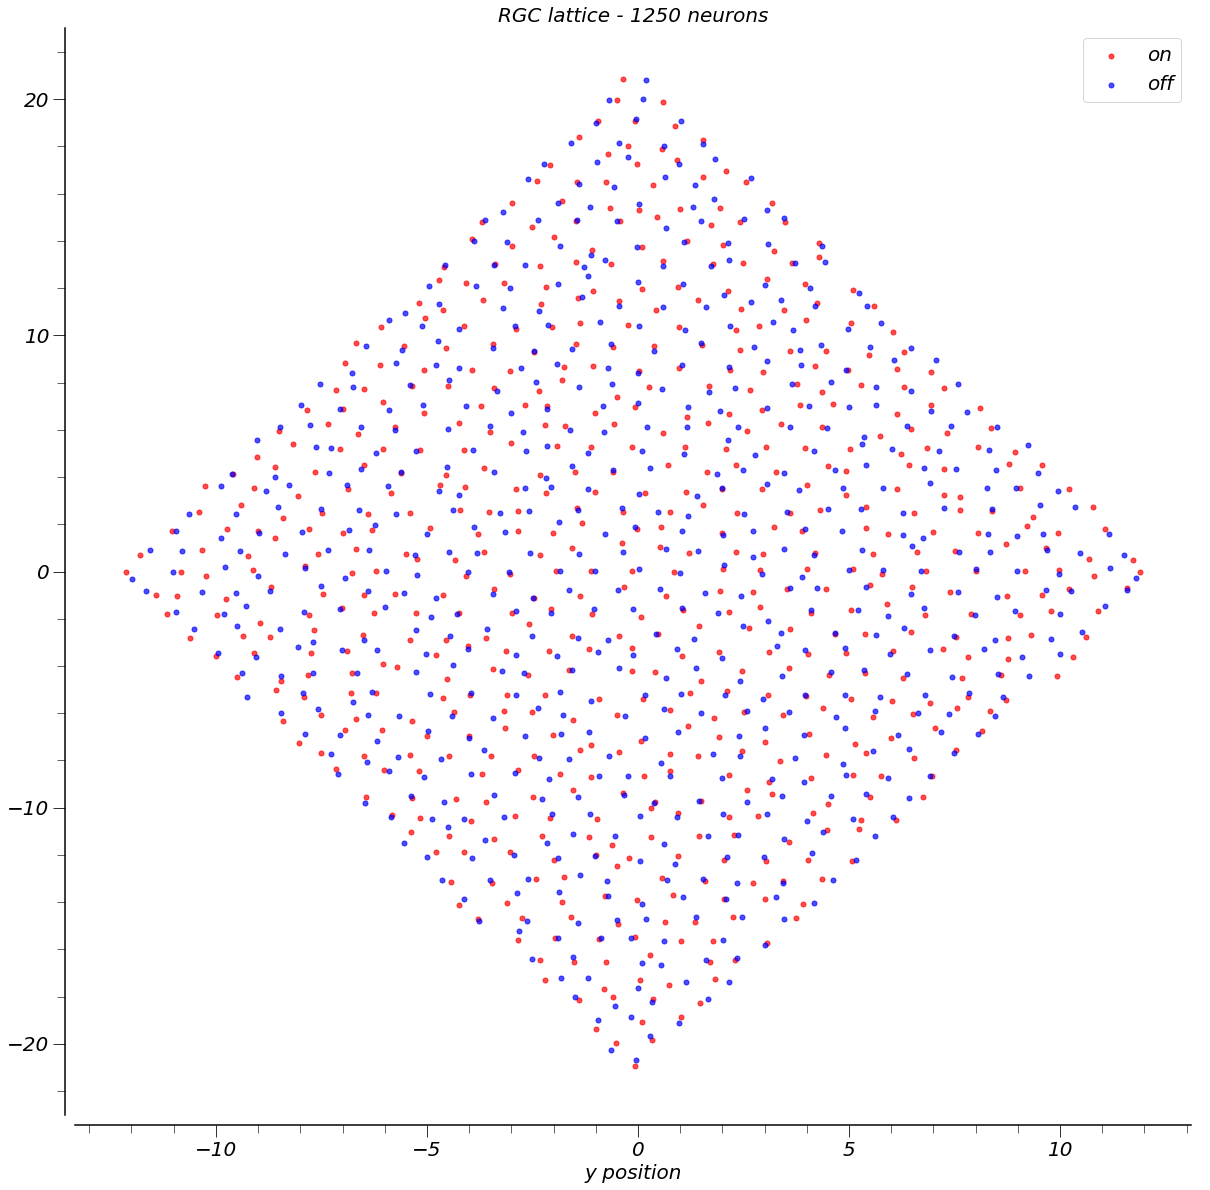

In [4]:
latNum = latNum+1;
# latNum = -1;

nsteps = 12;
sc_factor=1/2.0;
lm=1;
sig_ringach = 0.155;

on_locs, off_locs = lgn_v1.rgc_lattice(nsteps, sc_factor=sc_factor, lmda=lm, sig_pos=sig_ringach)
f = plt.figure(figsize=(20, 20));

plt.scatter(on_locs[:, 0], on_locs[:, 1], c='r', alpha=0.7, label='on');
plt.scatter(off_locs[:, 0], off_locs[:, 1], c='b', alpha=0.7, label='off');

plt.axis('equal');
plt.axis('tight');
plt.xlabel('x position')
plt.xlabel('y position')
plt.title('RGC lattice - %d neurons' % (len(on_locs)+len(off_locs)));
plt.legend();
sns.despine(offset=10)

In [6]:
### Now, compute the distribution of distances between locations - first within class then, across
# within class:
on_min = [];
off_min = [];
for i,j in zip(on_locs, off_locs):
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    on_min.append(np.partition(np.sqrt(np.sum(np.square(i - on_locs), 1)), 1)[1])
    off_min.append(np.partition(np.sqrt(np.sum(np.square(j - off_locs), 1)), 1)[1])

for dta, lbl in zip((on_min, off_min), ('on', 'off')):
    mn, sd = np.mean(dta), np.std(dta);
    cv = np.divide(sd, mn);
    print('%s: mn %.2f +- %.2f --- CV %.3f' % (lbl, mn, sd, cv))
    
# independent of class:
all_locs = np.vstack((on_locs, off_locs));
both_min = [];
for i in all_locs:
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    both_min.append(np.partition(np.sqrt(np.sum(np.square(i - all_locs), 1)), 1)[1])
    
mn_both, sd_both = np.mean(both_min), np.std(both_min);
cv_both = np.divide(sd_both, mn_both);
print('%s: mn %.2f +- %.2f --- CV %.3f' % ('all locations', mn_both, sd_both, cv_both))

on: mn 0.74 +- 0.14 --- CV 0.191
off: mn 0.75 +- 0.14 --- CV 0.185
all locations: mn 0.27 +- 0.13 --- CV 0.498


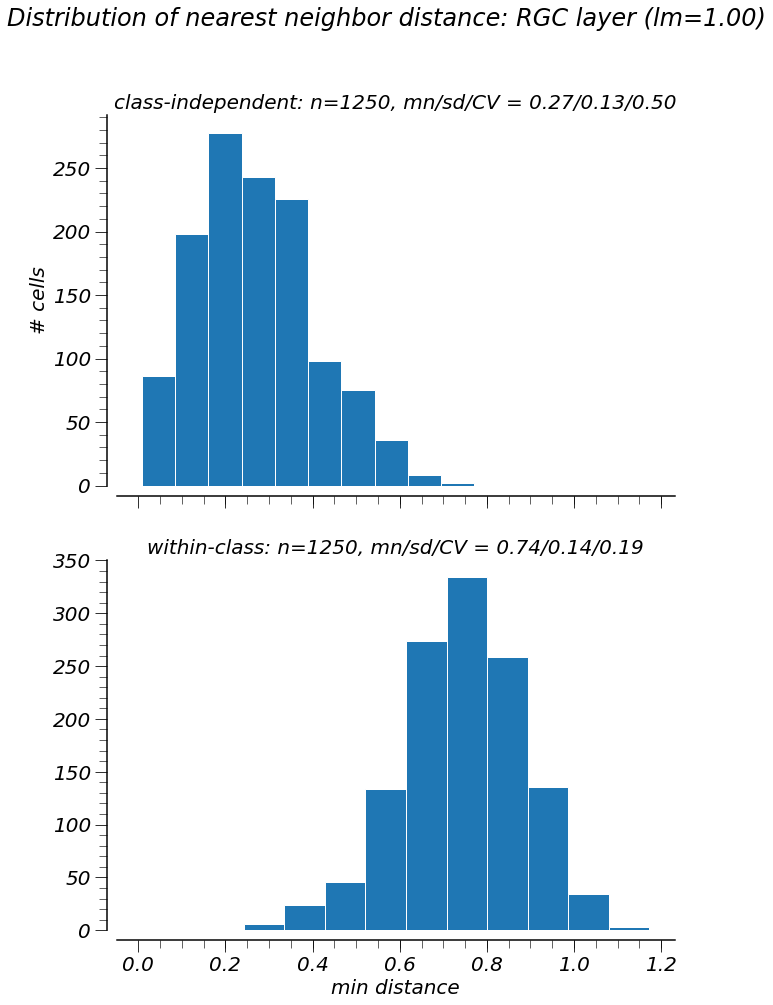

In [7]:
all_dist_within = np.hstack((on_min, off_min));
all_mean, all_std = np.mean(all_dist_within), np.std(all_dist_within);
all_cv = np.divide(all_std, all_mean)

fDistr, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
fDistr.suptitle('Distribution of nearest neighbor distance: RGC layer (lm=%.2f)' % lm)

sns.despine(offset=10)

ax[0].hist(both_min);
ax[0].set_title('class-independent: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(both_min), mn_both, sd_both, cv_both));
ax[0].set_ylabel('# cells');

ax[1].hist(all_dist_within);
ax[1].set_title('within-class: n=%d, mn/sd/CV = %.2f/%.2f/%.2f' % (len(all_dist_within), all_mean, all_std, all_cv));
ax[1].set_xlabel('min distance');


In [9]:
### Save the lattice and the distributions

f_lat = [f, fDistr]; # in future, add fLat before this

curr_name = 'lat%03d_distr.pdf' % (latNum)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + curr_name);
for fc in f_lat:
    # first, save png of just the one figure
    # then, add to the pdf
    pdfSv.savefig(fc)
    plt.close(fc)
pdfSv.close();

### Then, create the LGN layer

_"The layer of LGN neurons was constructed by replicating the original RGC layer and adding 1.5 times more receptive fields. This was done by random sampling (with replacement) to result in a total of 2.5 times the number of original RGCs. This assumes that each LGN neuron receives dominant input from only one retinal afferent (Cleland and Lee 1985; Cleland et al. 1971)"_ - Ringach, 2004

In [10]:
# resampling 1.5x the RGC layer is for cat
# -- we can assume 1:1 for RGC:LGN in monkey, thus no resampling needed, so n_to_draw is 0!
resamp_factor = 0;
LGN_locs, LGN_ids, on_inds, off_inds = lgn_v1.lgn_lattice(on_locs, off_locs, resample_factor=resamp_factor);

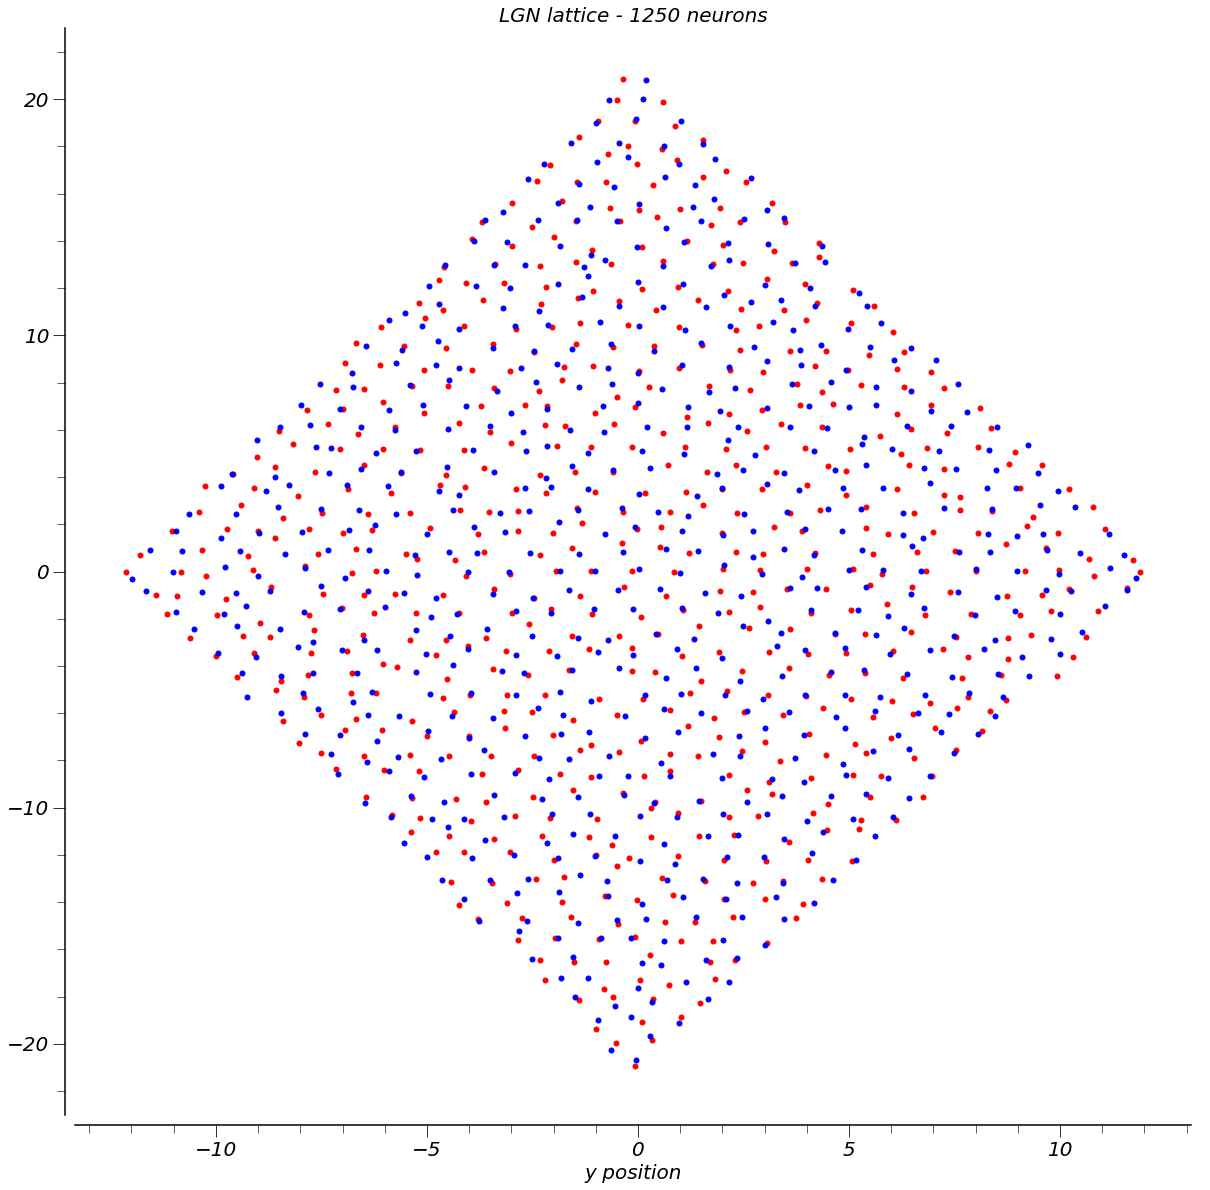

In [11]:
# now, let's plot
# -- by reducing the "alpha" of each point, it's visible which points have been resampled
#      simply because the multiple overlaid points will appear darker!

to_plt = 1;

if to_plt:
    fLGN = plt.figure(figsize=(20, 20))

for inds, lbl, clr in zip((on_inds, off_inds), ('on', 'off'), ('r', 'b')):

    # on or off?    
    if to_plt:
        if resamp_factor == 0: # i.e. no extra resampling done...so LGN is just RGC
            alph = 1;
        else: # we did sompe resampling, so make the points transparent to see overlay
            alph = 0.1;
        curr_locs = LGN_locs[inds]
        plt.scatter(curr_locs[:, 0], curr_locs[:, 1], c=clr, alpha=alph, label=lbl)

if to_plt:
    sns.despine(offset=10)
    plt.axis('equal');
    plt.axis('tight');
    plt.xlabel('x position')
    plt.xlabel('y position')
    plt.title('LGN lattice - %d neurons' % len(LGN_locs))
    # now, trim the figure so that we make it a square
#     plt.xlim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);
#     plt.ylim([-np.minimum(10, nsteps)*lm, np.minimum(10, nsteps)*lm]);

### Now, draw LGN inputs for the V1 layer, and assign synaptic weights

"Next, we have to decide on the size of the RGC center. Wassle and co-workers have shown that the dendritic field radius is approximately the same as the mean nearest neighbor distance in the mosaic, which equals  0.76 . However, the physiological receptive field center is slightly larger than the actual dendritic tree, with the amplitude decaying to about 30% of its peak at the boundary of the dendritic tree (Peichl and Wassle 1983). To match this value, we selected the center of the RGC to be a two-dimensional Gaussian function with SD equal to $\sigma_{ctr} = 0.7 * \lambda$.

Then, probability of LGN (at $\vec{x}$) and V1 connection (at $\vec{y}$) is $p = p_{max} \exp(-\frac{{\mid{\vec{x}-\vec{y}}}\mid^2}{2\sigma_{conn}^2})$ where $\sigma_{conn} = 0.97*\sigma_{ctr}$ and $p_{max}=0.85$

In [101]:
autoreload.reload(lgn_v1)

<module 'lgn_v1' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/lgn_v1.py'>

In [102]:
exNum = exNum + 1;

v1_loc = None
lcs, stz, prms = lgn_v1.v1_cell(v1_loc=v1_loc, LGN_locs=LGN_locs, LGN_ids=LGN_ids)

### Sample the LGN fields, sum them up (with sign) to get the V1 field

In [104]:
n_samps = 1001;
bndsMult = 70;
tot_field, sums, all_fields = lgn_v1.v1_sample(lcs, stz, prms, bndsMult=bndsMult, n_samps=n_samps)

#### Plot!

In [105]:
ok_x = np.logical_and(all_coords[:, 0] > xlims[0], all_coords[:, 0] < xlims[1])
ok_y = np.logical_and(all_coords[:, 1] > ylims[0], all_coords[:, 1] < ylims[1])

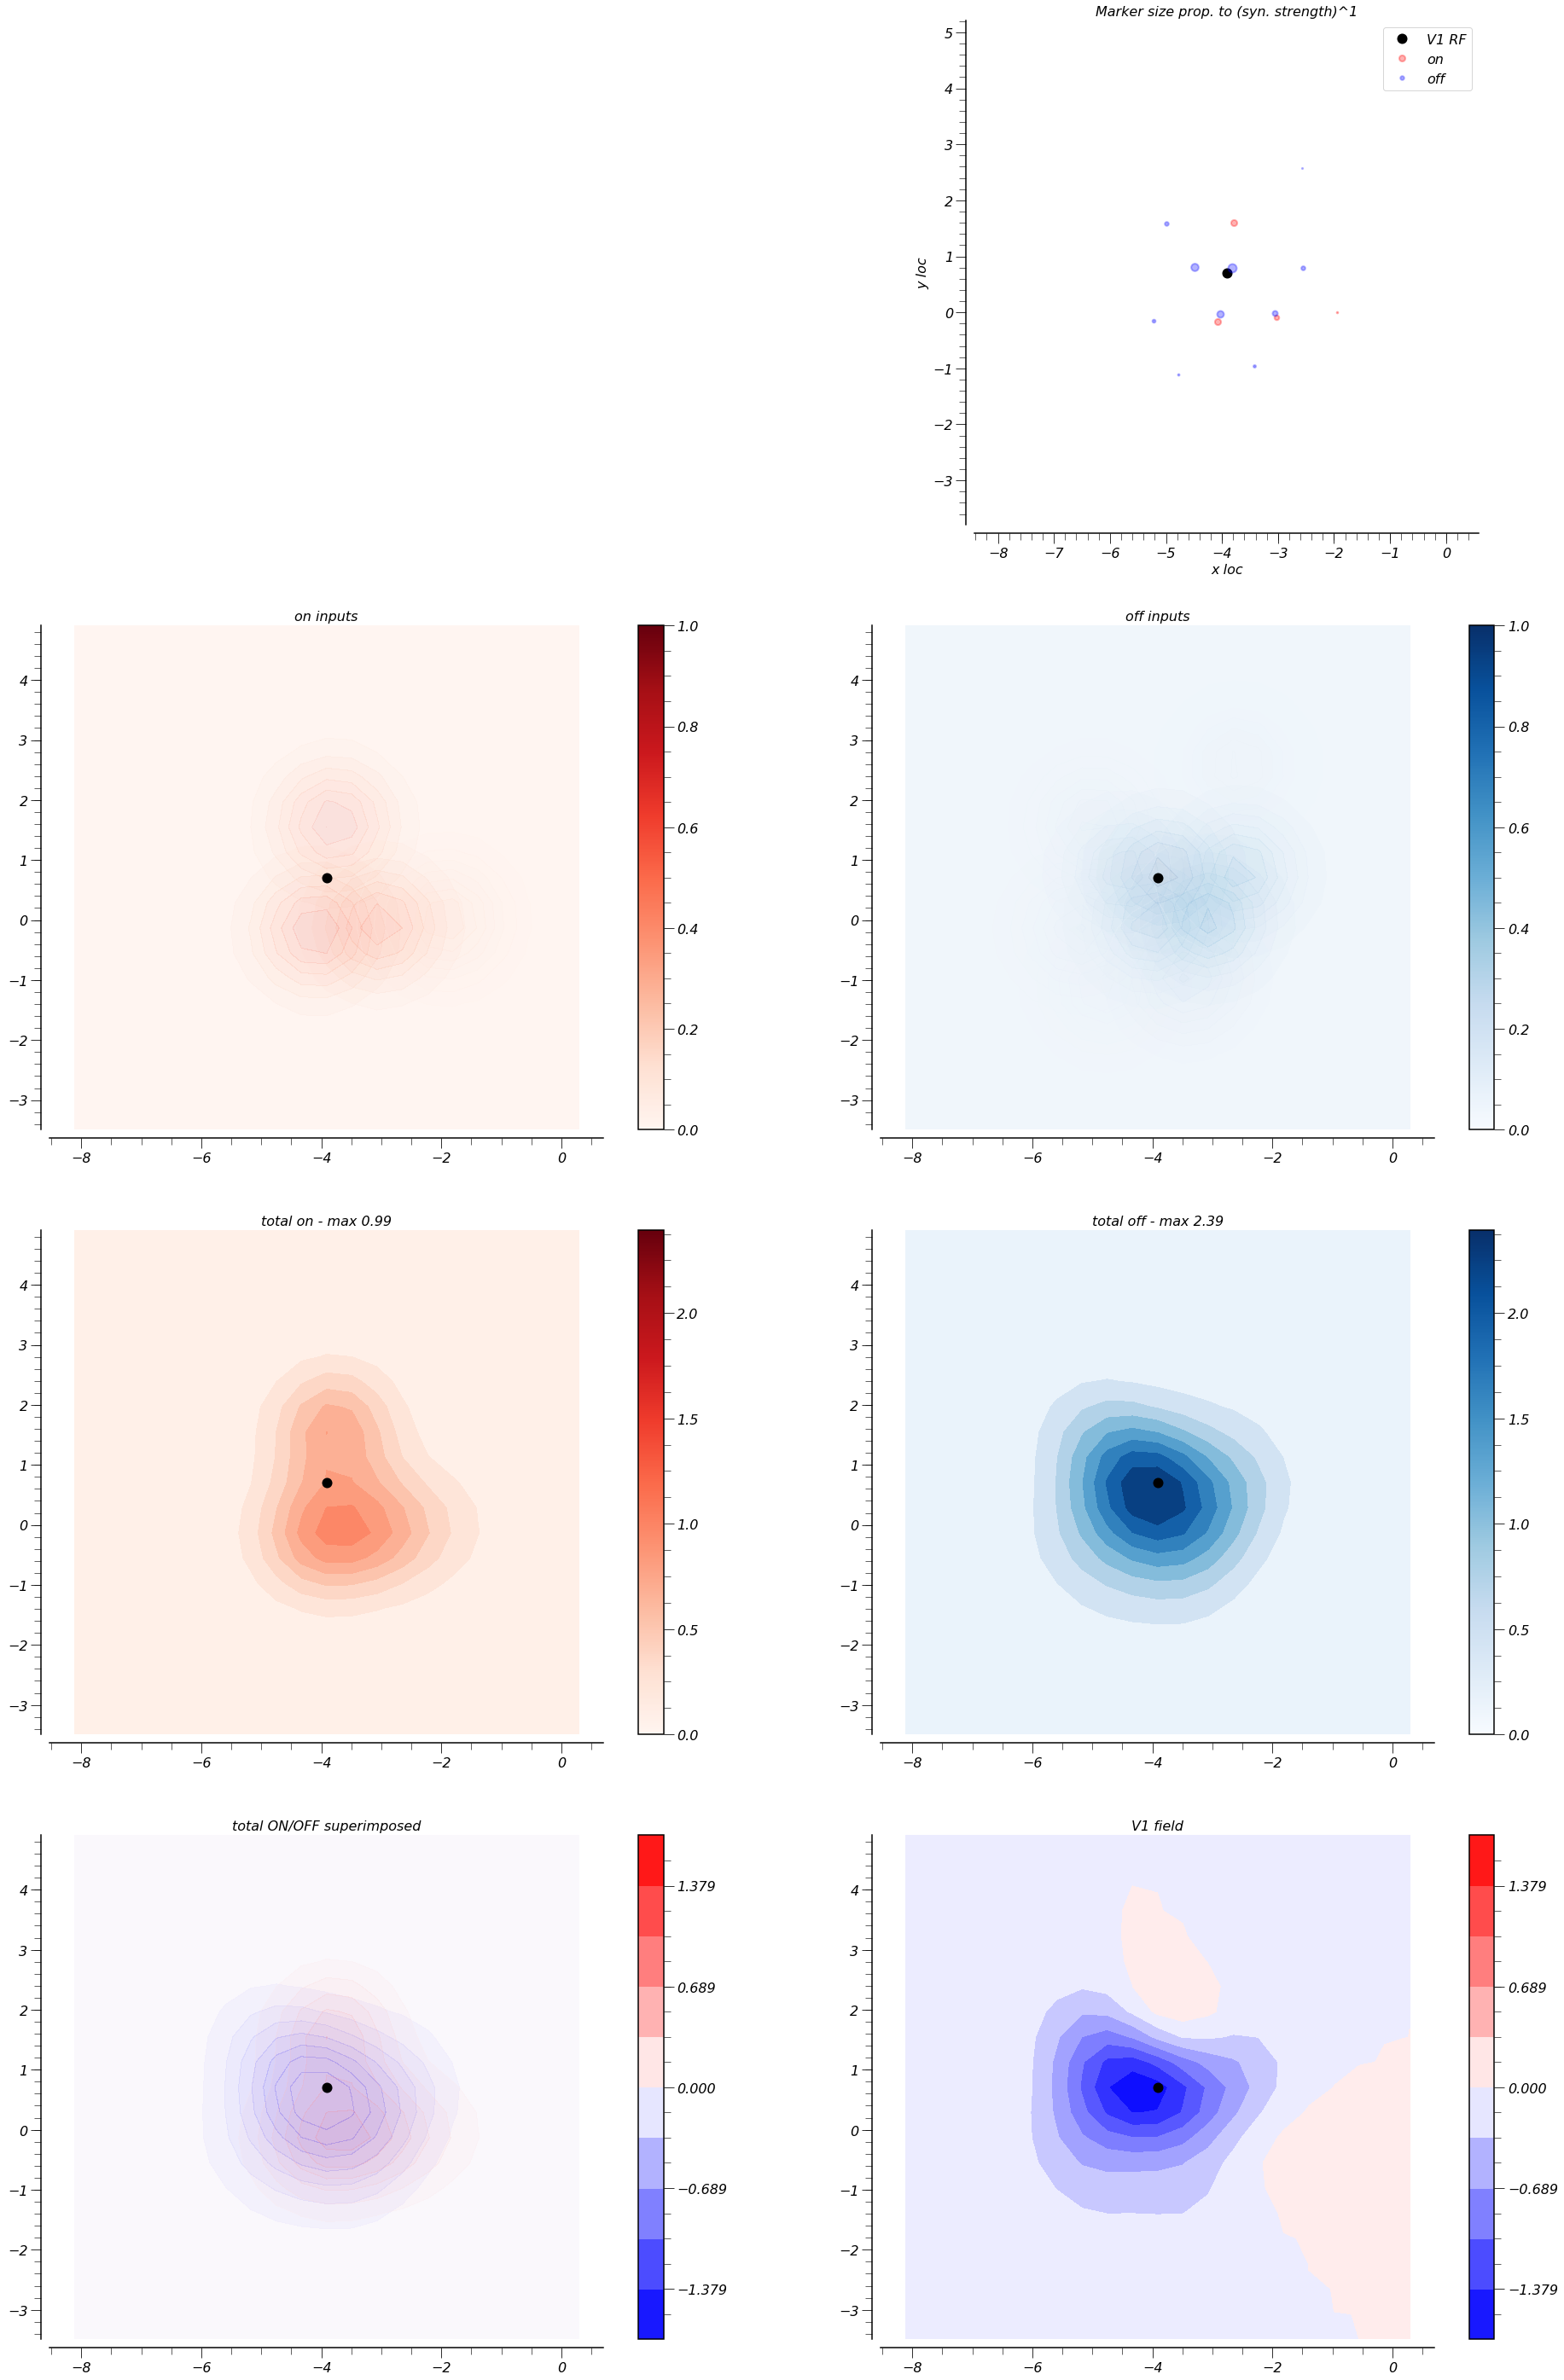

In [119]:
# quick aside: plot probability of connection as a function of calculated distance
# -- and which are actually connected

nrow, ncol = 4, 2
fConstr, ax = plt.subplots(nrow, ncol, figsize=(8*nrow, 25*ncol))

# some overall plot parameters, unpacking
v1_size = 10; # marker size for plot
v1_loc = prms['v1_loc']
near_thresh = prms['near_thresh']
bnds = near_thresh*bndsMult;
on_fields, off_fields = all_fields[0], all_fields[1];
on_sum, off_sum = sums[0], sums[1];

# # plot all possible connections and show which are made
ax[0, 0].axis('off')

# now, show the spatial location of these LGN fields relative to the V1 field
curr_on_locs = lcs[0]
curr_off_locs = lcs[1];
syn_wts = stz
clrs = ['r', 'b'];
lbls = ['on', 'off'];
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
for lc, syn_wt, clr, lbl in zip(lcs, syn_wts, clrs, lbls):
    [ax[0, 1].plot(l[0], l[1], 'o', c=clr, label=lbl, alpha=0.3, markersize=v1_size*np.power(syn_w, 1)) for l,syn_w in zip(lc, syn_wt)];
ax[0, 1].set_xlabel('x loc');
ax[0, 1].set_ylabel('y loc');
ax[0, 1].axis('square');
xlims = [v1_loc[0]-1.5*near_thresh, v1_loc[0]+1.5*near_thresh];
ylims = [v1_loc[1]-1.5*near_thresh, v1_loc[1]+1.5*near_thresh];
ax[0, 1].set_xlim(xlims);
ax[0, 1].set_ylim(ylims);
ax[0, 1].legend();
ax[0, 1].set_title('Marker size prop. to (syn. strength)^1');

### and now, the real plotting
# - first, get the grid to sample
xs = np.linspace(-bnds, bnds, n_samps) + v1_loc[0];
ys = np.linspace(-bnds, bnds, n_samps) + v1_loc[1];
xcoor, ycoor = np.meshgrid(xs, ys);
all_coords = np.transpose(np.vstack((xcoor.ravel(), ycoor.ravel())));
# - then, what is the subsampled region we actually want to plot?
# -- why? we only evaluate and plot the wanted subset, rather than just put x/ylims on the plot, to reduce filesize
ok_x = np.logical_and(all_coords[:, 0] > xlims[0], all_coords[:, 0] < xlims[1])
ok_y = np.logical_and(all_coords[:, 1] > ylims[0], all_coords[:, 1] < ylims[1])
plt_inds = np.where(np.logical_and(ok_x, ok_y))
plt_xcoor = np.unique(all_coords[plt_inds, 0]);
plt_ycoor = np.unique(all_coords[plt_inds, 1]);

# first, ON
for i in range(len(on_fields)):
    curr_field = on_fields[i][plt_inds]
    curr_plt = np.reshape(curr_field, (len(plt_xcoor), len(plt_ycoor)));
    ax[1, 0].contourf(plt_xcoor, plt_ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(curr_plt)
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 0]);
ax[1, 0].set_title('on inputs')
    
# then, OFF
off_fields = all_fields[1];
for i in range(len(off_fields)):
    curr_field = off_fields[i][plt_inds];
    curr_plt = np.reshape(curr_field, (len(plt_xcoor), len(plt_ycoor)));
    ax[1, 1].contourf(plt_xcoor, plt_ycoor, curr_plt, alpha=0.2, vmin = 0., vmax = 1., cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(curr_field)
m.set_clim(0, 1)
plt.colorbar(m, ax=ax[1, 1]);
ax[1, 1].set_title('off inputs')

# - then, which is stronger, overall - on or off?
mx_resp = np.maximum(np.max(on_sum), np.max(off_sum));

# --- on sum
on_plt = np.reshape(on_sum[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
ax[2, 0].contourf(plt_xcoor, plt_ycoor, on_plt, vmin = 0, vmax = mx_resp, cmap=cm.Reds);
m = plt.cm.ScalarMappable(cmap=cm.Reds)
m.set_array(on_plt)
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 0]);
ax[2, 0].set_title('total on - max %.2f' % np.max(on_sum))
    
# --- off sum
off_plt = np.reshape(off_sum[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
ax[2, 1].contourf(plt_xcoor, plt_ycoor, off_plt, vmin = 0, vmax = mx_resp, cmap=cm.Blues);
m = plt.cm.ScalarMappable(cmap=cm.Blues)
m.set_array(off_plt)
m.set_clim(0, mx_resp)
plt.colorbar(m, ax=ax[2, 1]);
ax[2, 1].set_title('total off - max %.2f' % np.max(off_sum))

# NOW, get the full V1 field
v1_field = tot_field
v1_plot = np.reshape(v1_field[plt_inds], (len(plt_xcoor), len(plt_ycoor)));
mn, mx = np.min(v1_plot), np.max(v1_plot); mx_ab = np.maximum(np.abs(mn), np.abs(mx));
ax[3, 1].contourf(plt_xcoor, plt_ycoor, v1_plot, vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
ax[3, 1].set_title('V1 field')

m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(v1_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 1]);

# -- and the two (total ON/total OFF), superimposed
ax[3, 0].contourf(plt_xcoor, plt_ycoor, -off_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);
ax[3, 0].contourf(plt_xcoor, plt_ycoor, on_plt, vmin = -mx_ab, alpha=0.2, vmax = mx_ab, cmap=cm.bwr);

### Finally, at the end: put the v1 location, make axis equal
for rw in range(nrow-1):
    ax[rw+1, 0].axis('equal');
    ax[rw+1, 1].axis('equal');
    ax[rw+1, 0].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    ax[rw+1, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');
    # - and set the limits
#     ax[rw+1, 0].set_xlim(xlims);
#     ax[rw+1, 0].set_ylim(ylims);
#     ax[rw+1, 1].set_xlim(xlims);
#     ax[rw+1, 1].set_ylim(ylims);


m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(v1_plot)
m.set_clim(-mx_ab, mx_ab)
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[3, 0]);
ax[3, 0].set_title('total ON/OFF superimposed')

sns.despine(offset=10)

### Finally, get the FT to analyze tuning and plot

In [107]:
arb_lgn_field = all_fields[0][0]; # identical fields, anyway
v1_ft, sf_tune, ori_tune, lgn_tune, v1_reconstruct = lgn_v1.analyze_filt(tot_field, arb_lgn_field, n_samps, bnds)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/lgn_v1.py:266: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sf_curve = v1_ft[[x for x in np.unravel_index(plt_oris, v1_ft.shape, order='C')]]


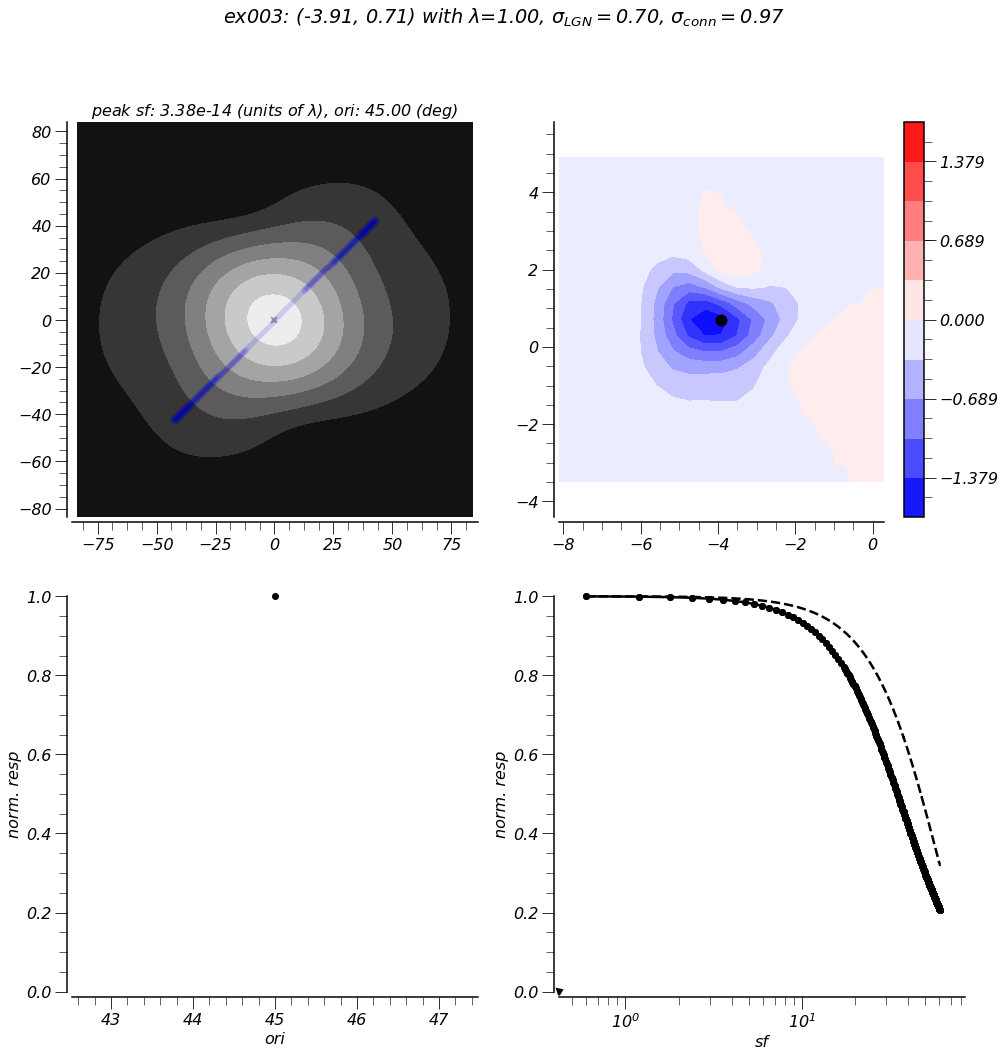

In [187]:
nr, nc = 2, 2;
fTune, ax = plt.subplots(nr, nc, figsize=(nc*8, nr*8))

### unpack
peak_sf = sf_tune['peak']
sf_curve = sf_tune['curve'];
sf_vals = sf_tune['sf_vals']
plt_oris = sf_tune['ori_vals']; # why? well, the SF tuning is evaluated at a particular orientation - which values?
peak_ori = ori_tune['peak'];
ori_curve = ori_tune['curve'];
ori_vals = ori_tune['ori_vals'];
plt_sfs = ori_tune['sf_vals']; # why? well, the ORI tuning is evaluated at a particular SF - which values?                                                                                                                                                                  
# -- and, don't forget, the LGN tuning!                                                                                                                                                                                                                                     
lgn_sf_vals = lgn_tune['sf_vals'];
lgn_curve = lgn_tune['curve'];
# -- and and, for the title
lm = prms['lmda'];
sig_ctr = prms['sig_ctr'];
sig_conn = prms['sig_conn'];

#####
### plot the Fourier representation of the filter
#####
# - and what frequencies?? well, [-n_samps/2, n_samps/2]*freq_scale
samp_step = np.round(2*bnds/n_samps, 3);
freq_scale = samp_step;
freqs = freq_scale*np.linspace(-(n_samps/2), n_samps/2, n_samps)
xfreq, yfreq = np.meshgrid(freqs, freqs);
# let's only evaluate and plot the wanted subset of frequencies (rather than just put x/ylims on the plot, to reduce filesize)
plt_bound = np.maximum(15*peak_sf, .4*freqs[-1]);
plt_fr = np.where(np.logical_and(freqs >= - plt_bound, freqs <= plt_bound))[0];
plt_xfr, plt_yfr = freqs[plt_fr], freqs[plt_fr];
plt_xc, plt_yc = np.meshgrid(plt_fr, plt_fr)
# -- then, get the 2d coordinates to index into v1_ft
plt_coords = np.transpose(np.vstack((plt_xc.ravel(), plt_yc.ravel())));
# -- bad python? access the right coords, but then it flattens, so then reshape into 2D again
plt_v1ft = np.reshape(v1_ft[plt_coords[:, 0], plt_coords[:, 1]], (len(plt_fr), len(plt_fr)));
ax[0, 0].contourf(plt_xfr, plt_yfr, plt_v1ft, cmap=cm.gray);
# ax[0, 0].contourf(xfreq, yfreq, v1_ft, cmap=cm.gray);
ax[0, 0].axis('equal');
## where is the peak of the filter?
filt_peak = np.argmax(v1_ft);
xmax, ymax = np.unravel_index(filt_peak, v1_ft.shape, order='F')
ax[0, 0].plot(freqs[xmax], freqs[ymax], 'kx', markersize=6, alpha=0.3)
# - cut the plot to zoom in on the relevant frequencies
ax[0, 0].set_title(r'peak sf: %.2e (units of $\lambda$), ori: %.2f (deg)' % (peak_sf, peak_ori))


#####
# What is the tuning? i.e. SF and ORI?
#####
#####
## NOW -- plot sf tuning measurements (fixed ori)
#####
[ax[0, 0].scatter(freqs[x], freqs[y], c='b', alpha=0.03) for x,y in [np.unravel_index(p, xcoor.shape, order='F') for p in plt_oris]]; # NOTE: xcoor/ycoor are same shape -- full grid of coordinates
xmin = samp_step; # don't plot any SF values below this
ax[1, 1].plot(np.maximum(peak_sf, samp_step), 0, 'kv', clip_on=False)
# val_plt = np.where(sf_vals[sf_order]>=xmin);
xmin = samp_step; # don't plot any SF values below this
val_sfs = np.where(sf_vals>=xmin)
ax[1, 1].plot(sf_vals[val_sfs], np.divide(sf_curve[val_sfs], np.max(sf_curve)), 'k-o', clip_on=False)
ax[1, 1].set_xlabel('sf');
ax[1, 1].set_ylabel('norm. resp');
## -- and get the LGN filter tuning, too, at the same locations
ax[1, 1].plot(sf_vals[val_sfs], np.divide(lgn_curve[val_sfs], np.max(lgn_curve)), 'k--', clip_on=False)
ax[1, 1].set_xlim([xmin, plt_bound]);
ax[1, 1].set_ylim([0, 1]);
ax[1, 1].set_xscale('log')
#####
## THEN -- plot ori tuning measurements (fixed SF)
#####
[ax[0, 0].scatter(freqs[x], freqs[y], c='r', alpha=0.03) for x,y in [np.unravel_index(d, xcoor.shape, order='F') for d in plt_sfs]]
ax[1, 0].plot(ori_vals, np.divide(ori_curve, np.max(ori_curve)), 'k-o', clip_on=False)
ax[1, 0].set_xlabel('ori');
ax[1, 0].set_ylabel('norm. resp');
ax[1, 0].set_ylim([0, 1]);

#####
# --- show that we can reconstruct it back into the spatial domain
#####
# first, trim the reconstruction
v1_recon_flat = v1_reconstruct.ravel();
plt_v1_recon = v1_recon_flat[plt_inds]; # plt_inds is from above, as is plt_xcoor, plt_ycoor
curr_plt = np.reshape(plt_v1_recon, (len(plt_xcoor), len(plt_ycoor)));
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(curr_plt)
m.set_clim(-mx_ab, mx_ab)
ax[0, 1].contourf(plt_xcoor, plt_ycoor, curr_plt, vmin = -mx_ab, vmax = mx_ab, cmap=cm.bwr);
plt.colorbar(m, boundaries=np.linspace(-mx_ab, mx_ab, 11), ax=ax[0, 1]);
ax[0, 1].axis('equal');
# ax[0, 1].set_xlim(xlims);
# ax[0, 1].set_ylim(ylims);
ax[0, 1].plot(v1_loc[0], v1_loc[1], 'ko', markersize=v1_size, label='V1 RF');

sns.despine(offset=5)

# make overall title
fTune.suptitle(r'ex%03d: (%.2f, %.2f) with $\lambda$=%.2f, $\sigma_{LGN}=%.2f$, $\sigma_{conn}=%.2f$' % (exNum, v1_loc[0], v1_loc[1], lm, sig_ctr, sig_conn));